## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [17]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join, vstack, unique

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

It seems like most of the ground-based photometry is going to be contaminated by brighter field stars. That means that we'll have to 

In [18]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')
classified = join(bronze, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3')

In [19]:
targets = vstack([gold, classified])
targets = unique(targets, keys='wd_source_id', keep='last')
ps_photo = cc.photometry.fetch_photometry(targets['wd_source_id'].data)
targets = join(targets, ps_photo, keys_left='wd_source_id', keys_right='source_id', join_type='outer')

In [21]:
with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'rb') as f:
    gaia_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [22]:
source_ids = list(gaia_chains.keys())
radius_med = []
radius_low = []
radius_high = []

for wdid in source_ids:
    mcmc = np.percentile(gaia_chains[wdid][:,1],[16,50,84])
    unc = np.diff(mcmc)
    radius_med.append(mcmc[1])
    radius_low.append(unc[0])
    radius_high.append(unc[1])

radius_table = Table()
radius_table['wd_source_id'] = source_ids
radius_table['radius_med'] = radius_med
radius_table['radius_unc_low'] = radius_low
radius_table['radius_unc_high'] = radius_high
radius_table['e_radius'] = 0.5 * np.abs(radius_table['radius_unc_high'] + radius_table['radius_unc_low'])
radius_table['pct_error'] = radius_table['e_radius'] / radius_table['radius_med'] * 100

In [23]:
targets = join(targets, radius_table, keys='wd_source_id')

In [24]:
targets[['wd_source_id', 'wd_phot_g_mean_mag', 'wd_ra', 'wd_dec', 'cmd_radius', 'SpType', 'source', 'radius_med', 'radius_unc_high', 'radius_unc_low', 'pct_error']]

wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source,radius_med,radius_unc_high,radius_unc_low,pct_error
int64,float64,float64,float64,float64,bytes3,str3,float64,float64,float64,float64
321259125631010688,19.23906898498535,17.00341481267388,35.814406111886065,0.007481759418545218,--,--,0.008475700560839747,0.002173600346692865,0.0017771087726139992,23.306091873752084
2153552814748001792,19.824588775634766,284.65870302124665,57.78819239158009,0.0067775427053977004,--,ps1,0.006620200095525702,0.001029226057527484,0.0008013404990128209,13.825613502056406
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465250886754626,DA,ps1,0.00764926116123036,0.00036068842157526045,0.00036088207046571907,4.716602537367917
3121385658671190784,17.237316131591797,92.21438403314589,-0.9974533046455966,0.004651617068459436,DA,ps1,0.004695945651226099,5.2705364839208436e-05,5.0425217509995034e-05,1.0980810896126572
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007198684270318171,DA,ps1,0.00741740729823301,0.00019199873106711448,0.00019756634314366077,2.626019163755361
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007001884607420573,DA,ps1,0.0070391610485912755,0.0003332866969695215,0.0003231270652455029,4.662585197893649
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177497308360124,DA,des,0.006993361652513229,0.00010359095472473653,0.00013222424066482164,1.6859931396856362
4762592584885748608,19.42276954650879,81.08108195558329,-59.947727725271655,0.0059727301554456215,--,--,0.0064717455638964635,0.0008334475939073757,0.0008224752946767687,12.793479535273617
5309155039065680512,19.6861629486084,144.35886329588214,-53.31675538451881,0.006532989105105616,--,--,0.0071445323408034465,0.0007876298205144201,0.0007645846332919723,10.862953513006538


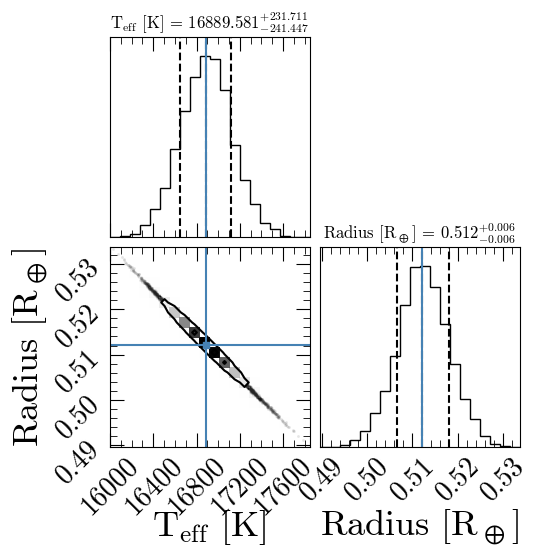

In [25]:
source = 3121385658671190784
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\oplus]$']
best_est = np.zeros((len(labels)))
unc = []

temp_chain = gaia_chains[source]
temp_chain[:, 1] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(temp_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()